#### Model Explainability

In [108]:
import os
import sys
from datetime import datetime
from pathlib import Path
import warnings

import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import shap
# Import local libraries
cwd = Path.cwd()  # Current directory
sys.path.append(str(cwd.parents[0]))  # This allows you to import from src
from definitions import LocationConfig, PROD_MODEL
lc = LocationConfig()

In [109]:
def generate_shap_plots(
    df_feature_importance,
    top_n=10,
    figsize=(4, 5),
    label=True,
    dpi=200,
):

    df_feature_importance["colours"] = "#EAE3D7"
    df_feature_importance.loc[df_feature_importance["corr"] > 0, "colours"] = "#E3F89D"
    df_feature_importance.loc[df_feature_importance["corr"] < 0, "colours"] = "#F2A580"

    plt.figure(figsize=figsize, dpi=dpi)
    ax = sns.barplot(
        data=df_feature_importance.head(top_n),
        x="value",
        y="feature",
        palette=df_feature_importance["colours"],
    )
    target_names = [
        i.replace("_", " ") for i in df_feature_importance.head(top_n).feature.values
    ]
    ax.set_yticklabels(target_names)
    if label:
        plt.ylabel("Feature")
        plt.xlabel("value")
    else:
        plt.ylabel("")
        plt.xlabel("")
    plt.show()

def get_feature_importance_df(model, x_test, y_test, features_list):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)

    if len(shap_values) == 2:
        shap_values = shap_values[1]
        
    df_shap = pd.DataFrame(shap_values, columns=features_list)
    df_shap["target"] = y_test
    df_shap_values = pd.DataFrame(data=shap_values, columns=features_list)
    df_feature_importance = pd.DataFrame(columns=["feature", "value"])
    
    for col in df_shap_values.columns:
        importance = df_shap_values[col].abs().mean()
        df_feature_importance.loc[len(df_feature_importance)] = [col, importance]
    df_feature_importance = df_feature_importance.sort_values(
        "value", ascending=False
    )

    df_feature_importance["corr"] = 0
    for i in features_list:
        row_corr = pd.DataFrame(
            {
                "shap": df_shap[i].values,
                "feature": x_test[i].astype(float).values,
            }
        )

        df_feature_importance.loc[df_feature_importance.feature == i, "corr"] = (
            row_corr.corr().values[0, 1]
        )

    return df_feature_importance

### Read data from source

In [122]:
%%time
# Read train/test data for model training
df_transformed_test = pd.read_csv("test.csv")

CPU times: total: 15.6 ms
Wall time: 13 ms


In [123]:
# Read the feature list from the table
df_features = pd.read_csv(lc.selected_features_table_name)
features_list = list(df_features['Feature'])

In [124]:
# Select the target column
target_column = 'price_range'

x_test = df_transformed_test[features_list]
y_test = df_transformed_test[target_column]

### Logistic Regression Explainability

In [125]:
# Load the Saved model for prediction
PROD_MODEL = "C://Users//LivinAlbert//Documents//Explainboard//models//logistic.joblib"
pipeline = joblib.load(PROD_MODEL)

In [126]:
 # Get the coefficient values in steps method
coef_values = pd.DataFrame(pipeline.coef_.transpose(),columns = ['value'])
# Create a DataFrame with the coefficients and column names 
coef_columns= pd.DataFrame(list(features_list),columns = ['feature']).copy() 
coef_table = pd.concat([coef_columns,coef_values],axis =1)
coef_table['corr'] = coef_table['value']

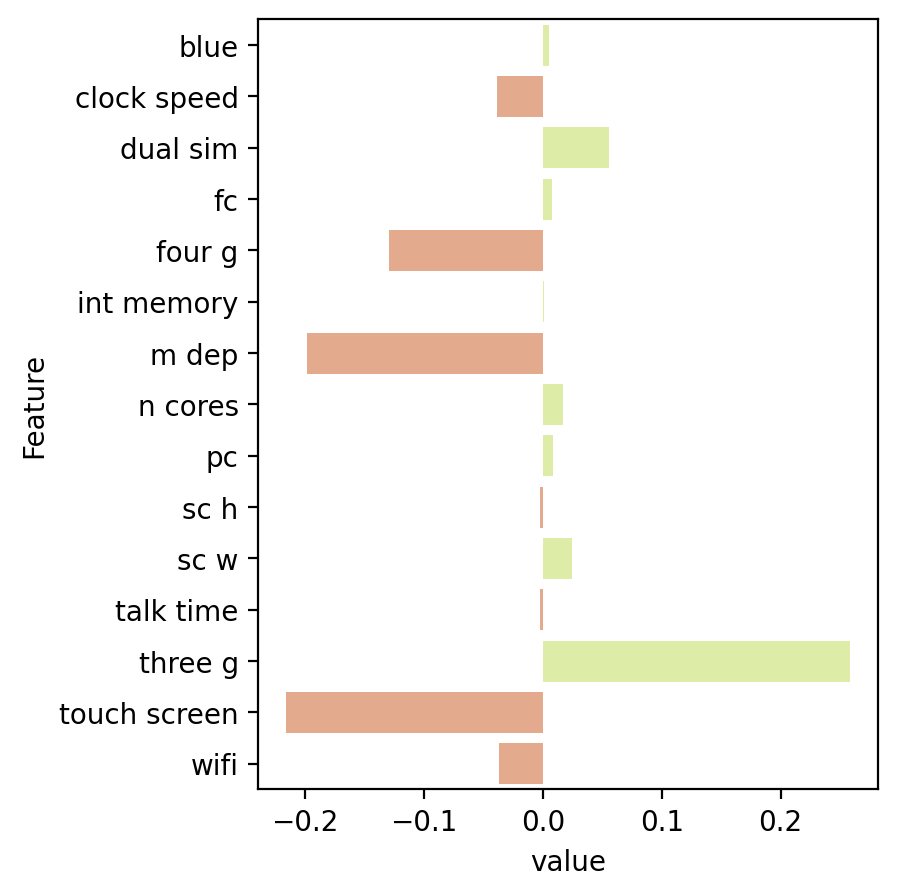

In [127]:
generate_shap_plots(coef_table, top_n=15)

### LightGBM Explainability - Shap

In [128]:
# Load the Saved model for prediction
PROD_MODEL = "C://Users//LivinAlbert//Documents//Explainboard//models//light_gbm.joblib"
pipeline = joblib.load(PROD_MODEL)

In [129]:
feature_importance = get_feature_importance_df(pipeline, x_test, y_test, features_list)
feature_importance

C:\Users\LivinAlbert\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



,feature,value,corr
5,int_memory,0.226852,0.206876
10,sc_w,0.208441,0.376643
1,clock_speed,0.192108,-0.136344
11,talk_time,0.187709,-0.178239
8,pc,0.165307,0.139768
9,sc_h,0.164161,0.003592
3,fc,0.160774,0.240770
6,m_dep,0.137534,-0.406508
13,touch_screen,0.133168,-0.534345
7,n_cores,0.115844,0.350098


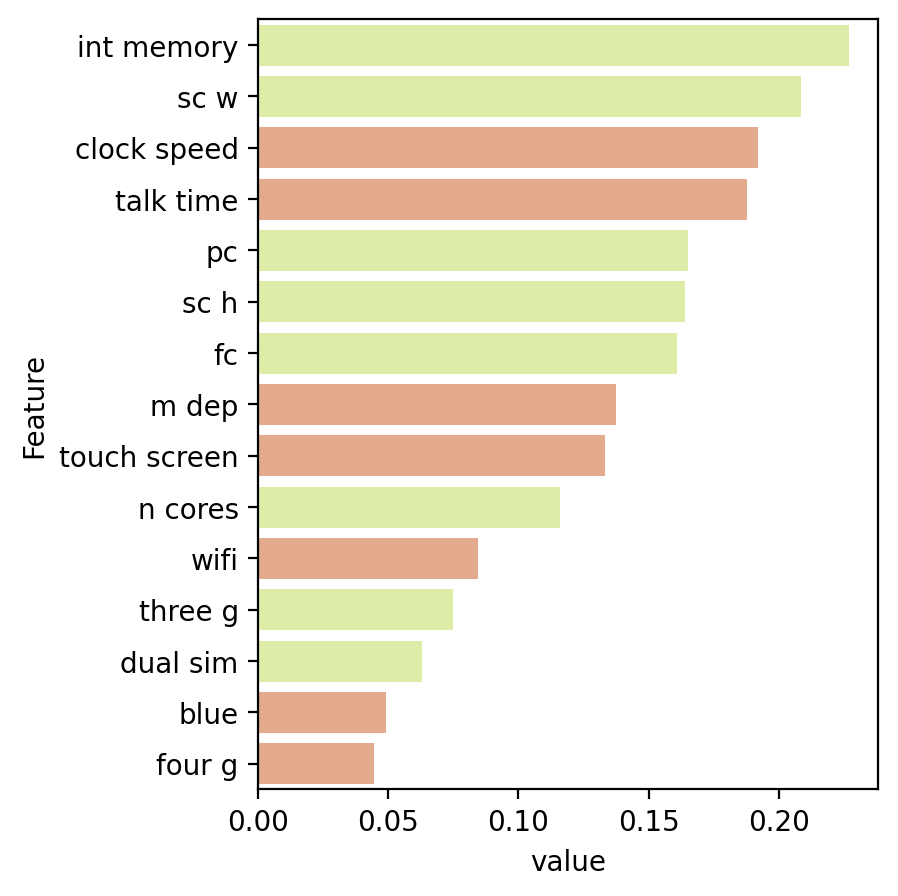

In [130]:
generate_shap_plots(feature_importance, top_n=15)

### LightGBM Explainability - Explainerboard

In [131]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
explainer = ClassifierExplainer(pipeline, x_test, y_test)

Note: model_output=='probability'. For LGBMClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


In [132]:
dashboard = ExplainerDashboard(explainer)
dashboard.run(port=8050, host='127.0.0.1')

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating predictions...
Calculating pred_percentiles...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.jobl